PROYECTO MACHINE LEARNING 

TEMA: Detectar fraude bancario

Detectar cuando un cliente va a tener problemas para pagar un préstamo y poder predecir impagos es muy importante para la gestión de riesgos del banco. 

Vamos a elaborar un modelo que replique la identificación de impagos.
Para ello vamos a emplear una dataset de un banco Checo con suficiente información sobre transacciones, préstamos e información de clientes totalmente anonimizado

Los datos los sacamos del siguiente link: https://relational.fit.cvut.cz/dataset/Financial

Seguimos las instrucciones para descargar el dataset y poder trabajar

In [68]:
import pymysql
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [69]:
database_host = 'relational.fit.cvut.cz'
username = 'guest'
password = 'relational'
database_name = 'financial'

db = pymysql.connect(host = database_host,
                     user = username,
                     password = password,
                     database = database_name)

In [70]:
query = "SELECT * FROM loan"
df = pd.read_sql(query,db)
df 

,loan_id,account_id,date,amount,duration,payments,status
0,4959,2,1994-01-05,80952,24,3373.0,A
1,4961,19,1996-04-29,30276,12,2523.0,B
2,4962,25,1997-12-08,30276,12,2523.0,A
3,4967,37,1998-10-14,318480,60,5308.0,D
4,4968,38,1998-04-19,110736,48,2307.0,C
...,...,...,...,...,...,...,...
677,7294,11327,1998-09-27,39168,24,1632.0,C
678,7295,11328,1998-07-18,280440,60,4674.0,C
679,7304,11349,1995-10-29,419880,60,6998.0,C
680,7305,11359,1996-08-06,54024,12,4502.0,A


In [71]:
query='''
SELECT *
FROM loan
JOIN account
ON loan.account_id = account.account_id
'''

dff=pd.read_sql(query,db)
dff.sample(10)

,loan_id,account_id,date,amount,duration,payments,status,account_id,district_id,frequency,date
113,5367,2064,1997-08-26,83628,36,2323.0,C,2064,54,POPLATEK MESICNE,1996-12-30
378,6313,6461,1997-06-15,150912,36,4192.0,C,6461,50,POPLATEK MESICNE,1996-07-17
303,6055,5181,1997-04-28,399120,60,6652.0,C,5181,75,POPLATEK MESICNE,1996-02-03
504,6736,8558,1994-06-14,288360,60,4806.0,C,8558,1,POPLATEK PO OBRATU,1994-02-27
301,6052,5164,1998-03-23,22356,36,621.0,C,5164,5,POPLATEK MESICNE,1997-05-13
490,6698,8327,1996-03-10,247728,48,5161.0,C,8327,1,POPLATEK TYDNE,1995-08-08
75,5253,1447,1997-06-03,100080,48,2085.0,C,1447,65,POPLATEK MESICNE,1997-02-20
491,6699,8330,1994-03-30,7656,24,319.0,A,8330,48,POPLATEK MESICNE,1993-03-28
470,6645,8041,1994-11-06,140400,36,3900.0,A,8041,1,POPLATEK MESICNE,1993-10-10
558,6922,9424,1997-08-26,83628,36,2323.0,C,9424,54,POPLATEK MESICNE,1996-12-30


In [72]:
dff_corriente = df.loc[(df['status'] == 'A') | (df['status'] == 'C')]
dff_default = df.loc[(df['status'] == 'B') | (df['status'] == 'D')]

In [73]:
query = '''
SELECT  loan.account_id,
        loan.date as date_loan,
        amount,
        duration,
        payments,
        status,
        frequency,
        account.date as date_acc,
        A4, A11, A12, A13, A14, A15, A16
FROM loan
JOIN account
ON loan.account_id = account.account_id
JOIN district
ON account.district_id = district.district_id
'''

df = pd.read_sql(query,db)

In [74]:
df['date_loan'] = pd.to_datetime(df.date_loan, format='%Y-%m-%d')
df['date_acc'] = pd.to_datetime(df.date_acc, format='%Y-%m-%d')
df['days_between'] = (df['date_loan'] - df['date_acc']).dt.days
df['n_inhabitants'] = df.A4
df['average_salary'] = df.A11
df['average_unemployment_rate'] = df[['A12', 'A13']].mean(axis=1)
df['entrepreneur_rate'] = df['A14']
df['average_crime_rate'] = df[['A15', 'A16']].mean(axis=1) / df['n_inhabitants']
df['default'] = (df['status'] == 'B') | (df['status'] == 'D')
df

,account_id,date_loan,amount,duration,payments,status,frequency,date_acc,A4,A11,...,A14,A15,A16,days_between,n_inhabitants,average_salary,average_unemployment_rate,entrepreneur_rate,average_crime_rate,default
0,2,1994-01-05,80952,24,3373.0,A,POPLATEK MESICNE,1993-02-26,1204953,12541,...,167,85677.0,99107,313,1204953,12541,0.315,167,0.076677,False
1,19,1996-04-29,30276,12,2523.0,B,POPLATEK MESICNE,1995-04-07,103347,9104,...,123,2299.0,2354,388,103347,9104,1.785,123,0.022512,True
2,25,1997-12-08,30276,12,2523.0,A,POPLATEK MESICNE,1996-07-28,228848,9893,...,96,5623.0,5887,498,228848,9893,4.360,96,0.025148,False
3,37,1998-10-14,318480,60,5308.0,D,POPLATEK MESICNE,1997-08-18,70646,8547,...,120,1563.0,1542,422,70646,8547,3.120,120,0.021976,True
4,38,1998-04-19,110736,48,2307.0,C,POPLATEK TYDNE,1997-08-08,51428,8402,...,120,999.0,1099,254,51428,8402,3.540,120,0.020397,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
677,11327,1998-09-27,39168,24,1632.0,C,POPLATEK MESICNE,1997-10-15,94725,9920,...,130,4289.0,4846,347,94725,9920,2.535,130,0.048219,False
678,11328,1998-07-18,280440,60,4674.0,C,POPLATEK MESICNE,1996-11-05,387570,9897,...,140,18721.0,18696,620,387570,9897,1.780,140,0.048271,False
679,11349,1995-10-29,419880,60,6998.0,C,POPLATEK TYDNE,1995-05-26,1204953,12541,...,167,85677.0,99107,156,1204953,12541,0.315,167,0.076677,False
680,11359,1996-08-06,54024,12,4502.0,A,POPLATEK MESICNE,1994-10-01,117897,8814,...,107,2112.0,2059,675,117897,8814,5.220,107,0.017689,False


In [75]:
query = '''
select trans.account_id, trans.amount as trans_amount, balance as trans_balance 
from trans
join loan
on trans.account_id = loan.account_id
and trans.date < loan.date
'''
df_trans = pd.read_sql(query,db)
df_trans

,account_id,trans_amount,trans_balance
0,2,1100,1100
1,2,20236,21336
2,2,20236,45286
3,2,20236,54631
4,2,30354,67530
...,...,...,...
54689,11362,93,17922
54690,11362,75,14889
54691,11362,73,15993
54692,11362,87,19331


In [76]:
n_trans = df_trans[['account_id', 'trans_amount']].groupby('account_id',as_index=False).count()
n_trans.columns = ['account_id', 'n_trans']
n_trans

,account_id,n_trans
0,2,54
1,19,80
2,25,164
3,37,116
4,38,55
...,...,...
677,11327,54
678,11328,106
679,11349,18
680,11359,147


In [77]:
df_trans2 = df_trans.groupby('account_id',as_index=False).mean()
df_trans2

,account_id,trans_amount,trans_balance
0,2,7954.333333,32590.759259
1,19,5856.350000,25197.137500
2,25,12113.981707,62991.408537
3,37,7572.034483,39954.034483
4,38,4716.200000,31383.581818
...,...,...,...
677,11327,7977.981481,55438.814815
678,11328,8138.754717,38619.084906
679,11349,24426.500000,59352.666667
680,11359,8708.775510,36480.238095


In [78]:
df = df.merge(df_trans2,how='left',left_on='account_id',right_on='account_id').merge(n_trans,how='left',left_on='account_id',right_on='account_id')
df

,account_id,date_loan,amount,duration,payments,status,frequency,date_acc,A4,A11,...,days_between,n_inhabitants,average_salary,average_unemployment_rate,entrepreneur_rate,average_crime_rate,default,trans_amount,trans_balance,n_trans
0,2,1994-01-05,80952,24,3373.0,A,POPLATEK MESICNE,1993-02-26,1204953,12541,...,313,1204953,12541,0.315,167,0.076677,False,7954.333333,32590.759259,54
1,19,1996-04-29,30276,12,2523.0,B,POPLATEK MESICNE,1995-04-07,103347,9104,...,388,103347,9104,1.785,123,0.022512,True,5856.350000,25197.137500,80
2,25,1997-12-08,30276,12,2523.0,A,POPLATEK MESICNE,1996-07-28,228848,9893,...,498,228848,9893,4.360,96,0.025148,False,12113.981707,62991.408537,164
3,37,1998-10-14,318480,60,5308.0,D,POPLATEK MESICNE,1997-08-18,70646,8547,...,422,70646,8547,3.120,120,0.021976,True,7572.034483,39954.034483,116
4,38,1998-04-19,110736,48,2307.0,C,POPLATEK TYDNE,1997-08-08,51428,8402,...,254,51428,8402,3.540,120,0.020397,False,4716.200000,31383.581818,55
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
677,11327,1998-09-27,39168,24,1632.0,C,POPLATEK MESICNE,1997-10-15,94725,9920,...,347,94725,9920,2.535,130,0.048219,False,7977.981481,55438.814815,54
678,11328,1998-07-18,280440,60,4674.0,C,POPLATEK MESICNE,1996-11-05,387570,9897,...,620,387570,9897,1.780,140,0.048271,False,8138.754717,38619.084906,106
679,11349,1995-10-29,419880,60,6998.0,C,POPLATEK TYDNE,1995-05-26,1204953,12541,...,156,1204953,12541,0.315,167,0.076677,False,24426.500000,59352.666667,18
680,11359,1996-08-06,54024,12,4502.0,A,POPLATEK MESICNE,1994-10-01,117897,8814,...,675,117897,8814,5.220,107,0.017689,False,8708.775510,36480.238095,147


In [79]:
query='''
select disp.account_id, card.type as card_type

from card
join disp 
on card.disp_id = disp.disp_id
join loan
on disp.account_id = loan.account_id
and card.issued < loan.date
WHERE disp.type = 'OWNER'
'''
df_card = pd.read_sql(query,db)
df_card

,account_id,card_type
0,105,classic
1,226,classic
2,276,classic
3,544,classic
4,666,classic
5,1480,classic
6,1766,classic
7,1869,classic
8,2116,classic
9,2262,classic


In [80]:
df = df.merge(df_card, how='left', left_on='account_id',right_on='account_id')
df['card_type'].fillna('No',inplace=True)
df

,account_id,date_loan,amount,duration,payments,status,frequency,date_acc,A4,A11,...,n_inhabitants,average_salary,average_unemployment_rate,entrepreneur_rate,average_crime_rate,default,trans_amount,trans_balance,n_trans,card_type
0,2,1994-01-05,80952,24,3373.0,A,POPLATEK MESICNE,1993-02-26,1204953,12541,...,1204953,12541,0.315,167,0.076677,False,7954.333333,32590.759259,54,No
1,19,1996-04-29,30276,12,2523.0,B,POPLATEK MESICNE,1995-04-07,103347,9104,...,103347,9104,1.785,123,0.022512,True,5856.350000,25197.137500,80,No
2,25,1997-12-08,30276,12,2523.0,A,POPLATEK MESICNE,1996-07-28,228848,9893,...,228848,9893,4.360,96,0.025148,False,12113.981707,62991.408537,164,No
3,37,1998-10-14,318480,60,5308.0,D,POPLATEK MESICNE,1997-08-18,70646,8547,...,70646,8547,3.120,120,0.021976,True,7572.034483,39954.034483,116,No
4,38,1998-04-19,110736,48,2307.0,C,POPLATEK TYDNE,1997-08-08,51428,8402,...,51428,8402,3.540,120,0.020397,False,4716.200000,31383.581818,55,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
677,11327,1998-09-27,39168,24,1632.0,C,POPLATEK MESICNE,1997-10-15,94725,9920,...,94725,9920,2.535,130,0.048219,False,7977.981481,55438.814815,54,No
678,11328,1998-07-18,280440,60,4674.0,C,POPLATEK MESICNE,1996-11-05,387570,9897,...,387570,9897,1.780,140,0.048271,False,8138.754717,38619.084906,106,No
679,11349,1995-10-29,419880,60,6998.0,C,POPLATEK TYDNE,1995-05-26,1204953,12541,...,1204953,12541,0.315,167,0.076677,False,24426.500000,59352.666667,18,No
680,11359,1996-08-06,54024,12,4502.0,A,POPLATEK MESICNE,1994-10-01,117897,8814,...,117897,8814,5.220,107,0.017689,False,8708.775510,36480.238095,147,classic


In [81]:
df_ml = df[['amount', 'duration', 'payments', 'days_between', 'n_inhabitants', 
            'average_salary', 'average_unemployment_rate', 'entrepreneur_rate', 
            'average_crime_rate', 'n_trans',
            'frequency', 'card_type', 'default']]
df_ml

,amount,duration,payments,days_between,n_inhabitants,average_salary,average_unemployment_rate,entrepreneur_rate,average_crime_rate,n_trans,frequency,card_type,default
0,80952,24,3373.0,313,1204953,12541,0.315,167,0.076677,54,POPLATEK MESICNE,No,False
1,30276,12,2523.0,388,103347,9104,1.785,123,0.022512,80,POPLATEK MESICNE,No,True
2,30276,12,2523.0,498,228848,9893,4.360,96,0.025148,164,POPLATEK MESICNE,No,False
3,318480,60,5308.0,422,70646,8547,3.120,120,0.021976,116,POPLATEK MESICNE,No,True
4,110736,48,2307.0,254,51428,8402,3.540,120,0.020397,55,POPLATEK TYDNE,No,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
677,39168,24,1632.0,347,94725,9920,2.535,130,0.048219,54,POPLATEK MESICNE,No,False
678,280440,60,4674.0,620,387570,9897,1.780,140,0.048271,106,POPLATEK MESICNE,No,False
679,419880,60,6998.0,156,1204953,12541,0.315,167,0.076677,18,POPLATEK TYDNE,No,False
680,54024,12,4502.0,675,117897,8814,5.220,107,0.017689,147,POPLATEK MESICNE,classic,False


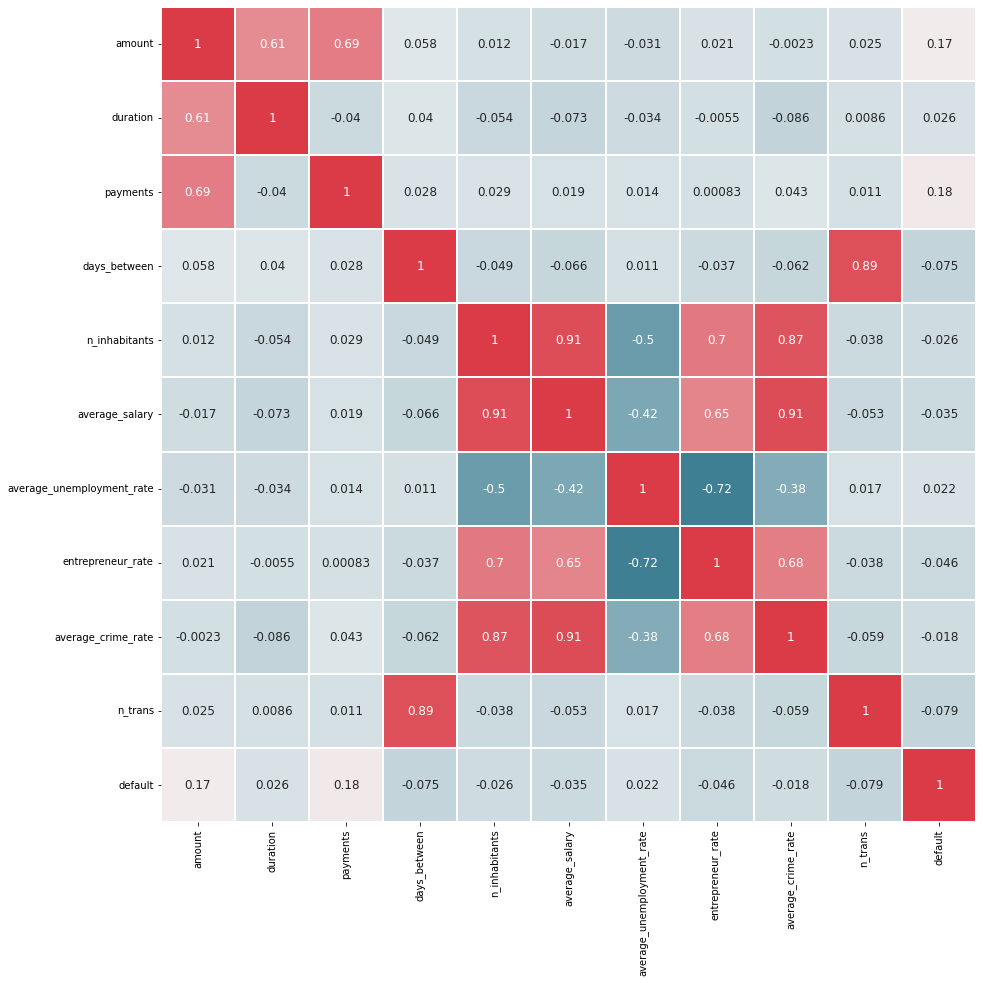

In [82]:
fig, ax = plt.subplots(figsize=(20, 15))
sns.heatmap(
        df_ml.corr(), 
        cmap = sns.diverging_palette(220, 10, as_cmap = True),
        square=True, 
        cbar=False,
        ax=ax,
        annot=True, 
        linewidths=0.1,vmax=1.0, linecolor='white',
        annot_kws={'fontsize':12 })
plt.show()

In [83]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler

In [84]:
df_ml2 = pd.get_dummies(df_ml,columns=['frequency','card_type'])
df_ml2['default'] = df_ml2.default.astype('int')
df_ml2.head()

,amount,duration,payments,days_between,n_inhabitants,average_salary,average_unemployment_rate,entrepreneur_rate,average_crime_rate,n_trans,default,frequency_POPLATEK MESICNE,frequency_POPLATEK PO OBRATU,frequency_POPLATEK TYDNE,card_type_No,card_type_classic,card_type_gold,card_type_junior
0,80952,24,3373.0,313,1204953,12541,0.315,167,0.076677,54,0,1,0,0,1,0,0,0
1,30276,12,2523.0,388,103347,9104,1.785,123,0.022512,80,1,1,0,0,1,0,0,0
2,30276,12,2523.0,498,228848,9893,4.360,96,0.025148,164,0,1,0,0,1,0,0,0
3,318480,60,5308.0,422,70646,8547,3.120,120,0.021976,116,1,1,0,0,1,0,0,0
4,110736,48,2307.0,254,51428,8402,3.540,120,0.020397,55,0,0,0,1,1,0,0,0


In [85]:
import numpy as np
from sklearn import datasets
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import train_test_split 
from sklearn.svm import SVC
# Set random seed
np.random.seed(0)

In [86]:
X = df_ml2.drop(columns=['default'])
y = df_ml2['default']

In [87]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=10)

In [88]:
print(type(X_test))

<class 'pandas.core.frame.DataFrame'>


In [89]:
df_test = pd.DataFrame(X_test)
df_test

,amount,duration,payments,days_between,n_inhabitants,average_salary,average_unemployment_rate,entrepreneur_rate,average_crime_rate,n_trans,frequency_POPLATEK MESICNE,frequency_POPLATEK PO OBRATU,frequency_POPLATEK TYDNE,card_type_No,card_type_classic,card_type_gold,card_type_junior
112,86184,12,7182.0,237,285387,10177,7.175,81,0.035016,42,1,0,0,1,0,0,0
7,265320,36,7370.0,636,105606,8254,3.230,97,0.021263,83,1,0,0,1,0,0,0
347,87216,48,1817.0,192,58796,9045,3.350,124,0.031669,33,1,0,0,1,0,0,0
401,25944,24,1081.0,260,118650,9832,3.890,114,0.050215,37,1,0,0,1,0,0,0
493,333648,48,6951.0,311,177686,10045,1.555,135,0.036297,97,1,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
297,53232,48,1109.0,638,226122,8994,4.295,110,0.041747,150,1,0,0,1,0,0,0
212,460980,60,7683.0,181,75232,8980,2.055,111,0.037464,26,1,0,0,1,0,0,0
423,30276,12,2523.0,498,228848,9893,4.360,96,0.025148,164,1,0,0,1,0,0,0
226,84600,36,2350.0,188,387570,9897,1.780,140,0.048271,32,1,0,0,1,0,0,0


In [90]:
df_test.to_csv(index=False)

'amount,duration,payments,days_between,n_inhabitants,average_salary,average_unemployment_rate,entrepreneur_rate,average_crime_rate,n_trans,frequency_POPLATEK MESICNE,frequency_POPLATEK PO OBRATU,frequency_POPLATEK TYDNE,card_type_No,card_type_classic,card_type_gold,card_type_junior\n86184,12,7182.0,237,285387,10177,7.175,81,0.03501561038169223,42,1,0,0,1,0,0,0\n265320,36,7370.0,636,105606,8254,3.23,97,0.021262996420657918,83,1,0,0,1,0,0,0\n87216,48,1817.0,192,58796,9045,3.35,124,0.03166882100823185,33,1,0,0,1,0,0,0\n25944,24,1081.0,260,118650,9832,3.89,114,0.050214917825537296,37,1,0,0,1,0,0,0\n333648,48,6951.0,311,177686,10045,1.555,135,0.03629717591706719,97,1,0,0,1,0,0,0\n186384,48,3883.0,645,128118,9317,6.735,97,0.053938556643094646,190,0,0,1,1,0,0,0\n48096,24,2004.0,454,105058,9272,3.01,118,0.04209579470387786,83,0,0,1,1,0,0,0\n73260,60,1221.0,164,285387,10177,7.175,81,0.03501561038169223,21,1,0,0,1,0,0,0\n73836,36,2051.0,188,119895,10446,8.35,90,0.04041035906418116,19,1,0,0,1,0,0

In [91]:
from pathlib import Path  
filepath = Path('entrega_2.csv')  
filepath.parent.mkdir(parents=True, exist_ok=True)  
df.to_csv(filepath)

In [92]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=10)

In [93]:
clf = RandomForestClassifier(random_state=10)
print('Acc:', cross_val_score(clf, X_train, y_train, cv=StratifiedKFold(n_splits=5), scoring='accuracy').mean())
print('F1:', cross_val_score(clf, X_train, y_train, cv=StratifiedKFold(n_splits=5), scoring='f1').mean())
print('ROC AUC:', cross_val_score(clf, X_train, y_train, cv=StratifiedKFold(n_splits=5), scoring='roc_auc').mean())

Acc: 0.8910087719298245
F1: 0.15934065934065936
ROC AUC: 0.6690101858925388


In [94]:
params = {
    'n_estimators': [10, 50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 5]
}

In [95]:
clf = GridSearchCV(RandomForestClassifier(random_state=10), param_grid=params, 
                   cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=10), scoring='f1')
clf.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=10, shuffle=True),
             estimator=RandomForestClassifier(random_state=10),
             param_grid={'max_depth': [None, 10, 20, 30],
                         'min_samples_leaf': [1, 2, 5],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [10, 50, 100, 200]},
             scoring='f1')

In [96]:
print(clf.best_params_)

{'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}


In [97]:
clf.best_score_

0.1682051282051282

In [98]:
clf = RandomForestClassifier(n_estimators=10,
                             max_depth=None,
                             min_samples_split=5,
                             min_samples_leaf=1,
                             random_state=11)

In [99]:
clf.fit(X_train, y_train)

RandomForestClassifier(min_samples_split=5, n_estimators=10, random_state=11)

Rendimiento Train

In [100]:
y_train_pred = clf.predict(X_train)
y_train_proba = clf.predict_proba(X_train)

In [101]:
print('Train Acc:', accuracy_score(y_train, y_train_pred))
print('Train F1:', f1_score(y_train, y_train_pred))
print('Train ROC AUC:', roc_auc_score(y_train, y_train_proba[:, 1]))

Train Acc: 0.9559748427672956
Train F1: 0.7529411764705882
Train ROC AUC: 0.9923460306158776


In [106]:
X_test

,amount,duration,payments,days_between,n_inhabitants,average_salary,average_unemployment_rate,entrepreneur_rate,average_crime_rate,n_trans,frequency_POPLATEK MESICNE,frequency_POPLATEK PO OBRATU,frequency_POPLATEK TYDNE,card_type_No,card_type_classic,card_type_gold,card_type_junior
112,86184,12,7182.0,237,285387,10177,7.175,81,0.035016,42,1,0,0,1,0,0,0
7,265320,36,7370.0,636,105606,8254,3.230,97,0.021263,83,1,0,0,1,0,0,0
347,87216,48,1817.0,192,58796,9045,3.350,124,0.031669,33,1,0,0,1,0,0,0
401,25944,24,1081.0,260,118650,9832,3.890,114,0.050215,37,1,0,0,1,0,0,0
493,333648,48,6951.0,311,177686,10045,1.555,135,0.036297,97,1,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
297,53232,48,1109.0,638,226122,8994,4.295,110,0.041747,150,1,0,0,1,0,0,0
212,460980,60,7683.0,181,75232,8980,2.055,111,0.037464,26,1,0,0,1,0,0,0
423,30276,12,2523.0,498,228848,9893,4.360,96,0.025148,164,1,0,0,1,0,0,0
226,84600,36,2350.0,188,387570,9897,1.780,140,0.048271,32,1,0,0,1,0,0,0


Matriz de confusión

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


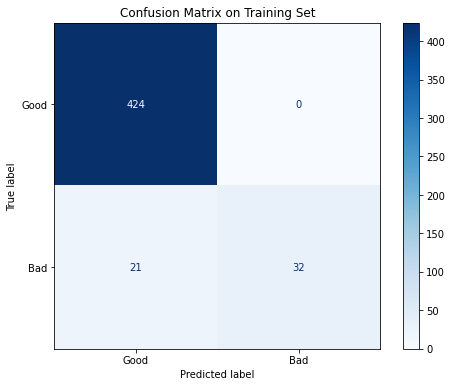

In [107]:
fig, ax = plt.subplots(figsize=(8, 6))
plot_confusion_matrix(clf, X_train, y_train, display_labels=['Good', 'Bad'], 
                      cmap=plt.cm.Blues, ax=ax)
ax.set_title('Confusion Matrix on Training Set')
plt.show()

Rendimiento test

In [103]:
y_test_pred = clf.predict(X_test)
y_test_proba = clf.predict_proba(X_test)

In [104]:
print('test Acc:', accuracy_score(y_test, y_test_pred))
print('test F1:', f1_score(y_test, y_test_pred))
print('test ROC AUC:', roc_auc_score(y_test, y_test_proba[:, 1]))

test Acc: 0.8731707317073171
test F1: 0.0
test ROC AUC: 0.5702341137123745


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


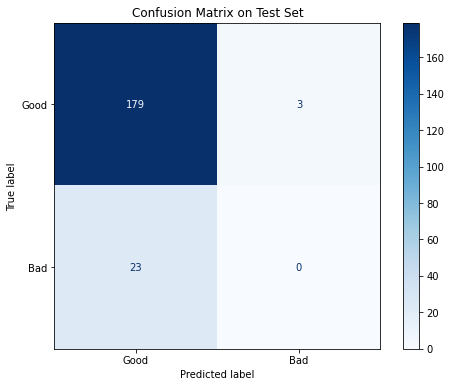

In [105]:
Fig, ax = plt.subplots(figsize=(8, 6))
plot_confusion_matrix(clf, X_test, y_test, display_labels=['Good', 'Bad'], 
                      cmap=plt.cm.Blues, ax=ax)
ax.set_title('Confusion Matrix on Test Set')
plt.show()

Curva ROC

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


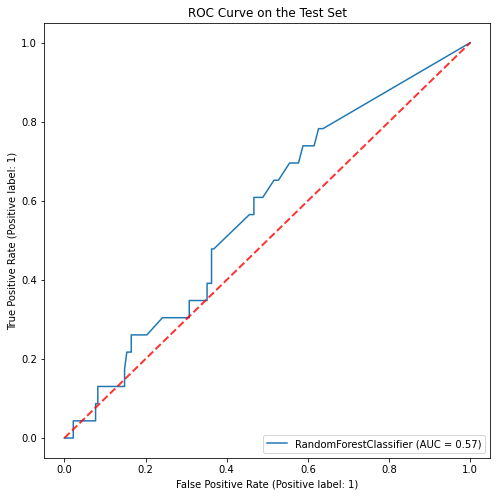

In [108]:
fig, ax = plt.subplots(figsize=(8, 8))
plot_roc_curve(clf, X_test, y_test, ax=ax)
ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
        label='Chance', alpha=.8)
ax.set_title('ROC Curve on the Test Set')
plt.show()

In [109]:
np.sum(clf.feature_importances_) 

1.0

In [110]:
feature_list = list(df_ml.columns)
feature_list

['amount',
 'duration',
 'payments',
 'days_between',
 'n_inhabitants',
 'average_salary',
 'average_unemployment_rate',
 'entrepreneur_rate',
 'average_crime_rate',
 'n_trans',
 'frequency',
 'card_type',
 'default']

Comentarios finales:

En este trabajo se ha realizado un modelo de aprendizaje para el sector bancario.
Se ha descrito el conjunto de datos, identificando las variables cable.
Se ha ido paso a paso desde la importacion de los datos hasta el modelado, utilizando MySQL conectado a Python, y varias librerias de esta para poder llevar a cabo el trabajo.
Se han extraido las variables claves y formado un tablón final para su desarrollo y aprendizaje.
Se ha utilizado el modelo Random Forest de metodo supervisado y obtenido una lista con las 5 principales variables que influyen en el impago de los clientes. 

Este modelo podría ser mejorado profundizando más en la extracción de variables clave, utilizando otro modelo más complejo así como la utilización de una base con más información sobre el impago ya que en este caso tipo solo el 10% del total de clientes estaban en situación de impago.

